In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from datetime import datetime, timedelta
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import FloatType
from pyspark.sql.functions import when, col, to_date, lag
from pyspark.sql.functions import to_timestamp, count, isnan, isnull, mean, rand
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pymongo import MongoClient

# Models
from pyspark.ml.regression import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet, plot


%matplotlib inline
plt.style.use('fivethirtyeight')
sc.setLogLevel("ERROR")

In [3]:
# Load Data for models
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"
client = MongoClient(mongo_uri)
db = client["ca2"]
collection = db["vaccin_tweets_analysis"]

# Convert MongoDB collection to pandas DataFrame
df = pd.DataFrame(list(collection.find()))
df = df[["timestamp","sentiment_score","is_retweet"]]
df["timestamp"] = df["timestamp"].apply(lambda x: pd.to_datetime(x).date())
df.rename(columns={"timestamp": "date"},inplace=True)

# Aggregate daily data
data = df.groupby('date').agg(avg_sentiment_score=('sentiment_score', 'mean'))
data['retweet_rate'] = df.groupby('date')['is_retweet'].mean()
data.reset_index(inplace=True)

In [4]:
start_date = pd.to_datetime("2020-04-01").date()
split_date = pd.to_datetime("2021-02-01").date()
end_date = pd.to_datetime("2021-05-01").date()

train = data.loc[(data.date >= start_date) & (data.date <= split_date)]
test = data.loc[(data.date >= split_date) & (data.date <= end_date)]

In [5]:
train.head()

,date,avg_sentiment_score,retweet_rate
0,2020-04-01,0.505337,0.632184
1,2020-04-02,0.495604,0.632787
2,2020-04-03,0.514191,0.641686
3,2020-04-04,0.249112,0.724858
4,2020-04-05,0.260608,0.696226


## Linear Regression Model

In [6]:
def build_vector(lag_periods, df_grouped, skip_to):
    window = Window.orderBy("date")
    
    # Create groups for 1,2,3,4,5,6,7 weekly seasons.
    for i in lag_periods:
        df_grouped = df_grouped.withColumn(f'sentiment_score_lag_{i}', lag(col('avg_sentiment_score'), i).over(window))
        
    # Filter out the first 7 rows with NAN
    filter_d = f"date > date'{skip_to}'"
    df_grouped = df_grouped.filter(filter_d)
    
    input_cols = [f'sentiment_score_lag_{i}' for i in lag_periods]
    input_cols.append("retweet_rate")
    input_cols
    
    # Assembler Vector - A feature transformer that merges multiple columns into a vector column.
    # https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html
    va = VectorAssembler(
        inputCols=input_cols,
        outputCol='features')
    
    return va.transform(df_grouped)

In [7]:
def get_linear_regresion_model(data):
    spark = SparkSession.builder.appName('Tweets').getOrCreate()
    spark_df = spark.createDataFrame(data)
    va_df = build_vector([1, 14, 28, 42, 56, 70, 84], spark_df, (start_date + timedelta(days=84+3)))
    train = va_df.filter(va_df.date <= split_date)
    test = va_df.filter(va_df.date >= split_date)
    
    # Linear regression model
    lr = LinearRegression(featuresCol='features', labelCol='avg_sentiment_score')

    # Fit the model
    model = lr.fit(train)
    
    # Forecast
    predictions = model.transform(test)

    return (model, predictions.select("prediction").toPandas().values.flatten())

## Sarima

In [8]:
def get_sarima_model(train):
    # Best model
    p = 1
    d = 0
    q = 1
    s = 28 # Sesonal Period
    P = 1
    D = 1
    Q = 1
    
    sarima = SARIMAX(train.values, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model = sarima.fit()
    return model

In [9]:
def get_profect_model(train):
    best_params= {
        'changepoint_prior_scale': 0.01,
        'seasonality_prior_scale': 10.0,
        'seasonality_mode': 'multiplicative',
        'changepoint_range': 0.8
    }
    train_data = train.rename(columns={"date": "ds", "avg_sentiment_score": "y"})
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        changepoint_range=best_params['changepoint_range'],
    )
    model.fit(train_data)
    three_months_prediction_dates = model.make_future_dataframe(periods=90, freq='D', include_history=False)
    three_months_predictions = model.predict(three_months_prediction_dates)
    return model, three_months_predictions.yhat

# Create Models

In [10]:
lr_model, lr_predictions = get_linear_regresion_model(data)
lr_rmse = np.sqrt(mean_squared_error(test["avg_sentiment_score"], lr_predictions))

/dsvm/tools/spark/current/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:41.454+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:41.480+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}


{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:42.627+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:43.049+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:43.051+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@v

{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:44.099+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:44.100+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-05-25T19:31:44.216+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@v

In [11]:
sarima_model =  get_sarima_model(train['avg_sentiment_score'])
sarima_predictions = sarima_model.get_forecast(steps=test.shape[0]).predicted_mean
sarima_rmse = np.sqrt(mean_squared_error(test["avg_sentiment_score"], sarima_predictions))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82250D-01    |proj g|=  1.26048D+00


 This problem is unconstrained.



At iterate    5    f= -2.16239D-01    |proj g|=  2.77143D-01

At iterate   10    f= -2.40796D-01    |proj g|=  2.87926D-01

At iterate   15    f= -2.55229D-01    |proj g|=  4.45757D-03

At iterate   20    f= -2.55423D-01    |proj g|=  1.94486D-03

At iterate   25    f= -2.55442D-01    |proj g|=  1.84711D-03

At iterate   30    f= -2.55444D-01    |proj g|=  2.81978D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   2.820D-04  -2.554D-01
  F = -0.25544354463835822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [12]:
prophet_model, prophet_predictions = get_profect_model(train)
prophet_predictions = prophet_predictions[:test.shape[0]] # make same shape as test data
prophet_rmse = np.sqrt(mean_squared_error(test["avg_sentiment_score"], prophet_predictions[:test.shape[0]]))

19:31:48 - cmdstanpy - INFO - Chain [1] start processing
19:31:48 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
sarima_rmse,lr_rmse,prophet_rmse

(0.14402473845154082, 0.08822479559894286, 0.11423793944054451)

# Prepare YCSB data for reports

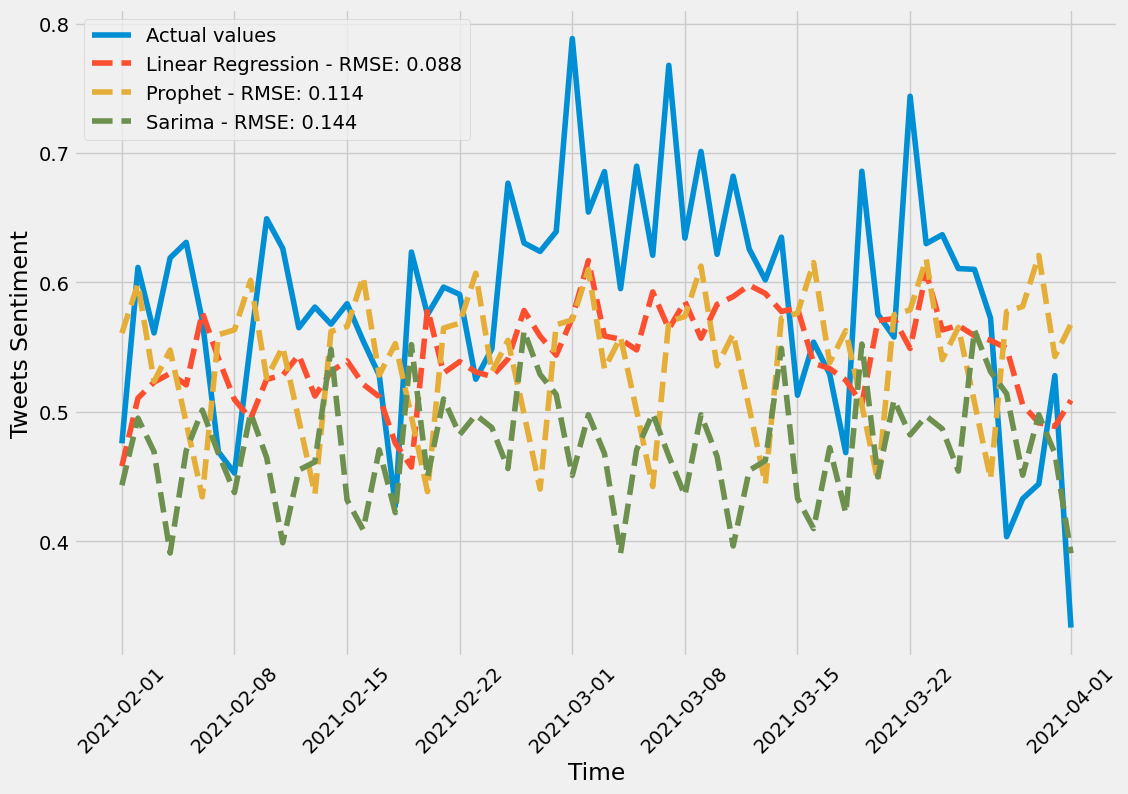

In [14]:
# Note there is missing dates on January 2021 on the dataset.
# https://archive.org/download/archiveteam-twitter-stream-2021-01

plt.figure(figsize=(12, 8))
#plt.plot(train_data, label='Training Data')
plt.plot(test.date, test.avg_sentiment_score, label='Actual values')
plt.plot(test.date, lr_predictions, label=f'Linear Regression - RMSE: {lr_rmse:.3f}', linestyle='--')
plt.plot(test.date, prophet_predictions, label=f'Prophet - RMSE: {prophet_rmse:.3f}' , linestyle='--')
plt.plot(test.date, sarima_predictions, label=f'Sarima - RMSE: {sarima_rmse:.3f}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Tweets Sentiment')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [15]:
# Load the data
df_ycsb = pd.read_csv('../ycsb/ycsb_report.csv')

#Convert to string 
df_ycsb['Operations'] = df_ycsb['Operations'].apply(lambda x: "10k" if x==10000 else ("100k" if x==100000 else "1M"))


# Define workload descriptions
workload_descriptions = {
    "a": "Workload A Update heavy workload: 50% read, 50% update operations",
    "b": "Workload B Read mostly workload: 95% read, 5% update operations.",
    "c": "Workload C Read only: 100% read operations.",
    "d": "Workload D Read latest workload: New records are read more frequently.",
    "e": "Workload E Short ranges: Range queries over the latest records.",
    "f": "Workload F Read-modify-write: Client read a record, modifies it, and writes back the changes.",
}


In [16]:
import dash
from dash import dcc
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
# Define the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the app layout
app.layout = html.Div([
    html.Div(
        dbc.Container(
            [
                html.H1("Covid-19", className="display-3"),
                html.P(
                    "Vaccines sentiment analysis. CA2 Raul Martin",
                    className="lead",
                )
            ],
            fluid=True,
            className="py-3",
        ),
        className="p-3 bg-light rounded-3",
    ),
    dbc.Container(
        [
            dcc.Tabs(id="tabs", value='tab-1', children=[
                dcc.Tab(label='YCSB', value='tab-1'),
                dcc.Tab(label='Data Prep', value='tab-2'),
                dcc.Tab(label='Timeseries Analysis', value='tab-3'),
            ]),
            html.Div(id='tabs-content')
        ]
    )
])


# Callback for tabs content
@app.callback(Output('tabs-content', 'children'),
              Input('tabs', 'value'))
def render_content(tab):
    if tab == 'tab-1':
        return [
            dbc.Row([
                dcc.Dropdown(
                    id='workload_dropdown',
                    options=[{'label': workload_descriptions[wl], 'value': wl} for wl in df_ycsb['WorkloadType'].unique()],
                    value=df_ycsb['WorkloadType'].unique()[0]
                )
            ]),
            dbc.Row([
                dbc.Col(dcc.Graph(id='comparison_graph')),
                dbc.Col(dcc.Graph(id='bar_plot')),
                dbc.Col(dcc.Graph(id='heatmap_plot'))
            ]),
            dbc.Row([
                dcc.Dropdown(
                    id='database_dropdown',
                    options=[{'label': db, 'value': db} for db in df_ycsb['Database'].unique()],
                    value=df_ycsb['Database'].unique()[0]
                )
            ]),
            dbc.Row([
                dbc.Col(dash_table.DataTable(
                    id='table',
                    columns=[{"name": i, "id": i} for i in df_ycsb.describe().columns],
                    data=df_ycsb[df_ycsb["Database"]==df_ycsb['Database'].unique()[0]].describe().to_dict('records')
                )),
            ])
        ]
    elif tab == 'tab-2':
        return html.Div([
            # Add your components for the Data Prep report
        ])
    elif tab == 'tab-3':
        return html.Div([
            # Add your components for the Timeseries Analysis report
        ])


# Define the callback to change DB
# Callback to update table
@app.callback(
    Output('table', 'data'),
    Input('database_dropdown', 'value'))
def update_table(selected_db):
    filtered_df = df_ycsb[df_ycsb['Database'] == selected_db]
    return filtered_df.describe().to_dict('records')
    
# Define the callback to update the graph
@app.callback(
    Output('comparison_graph', 'figure'),
    Input('workload_dropdown', 'value'))
def update_figure(selected_wl):
    filtered_df = df_ycsb[df_ycsb['WorkloadType'] == selected_wl]
    fig = px.line(filtered_df,
                  markers=True,
                  x='Operations',
                  y='AverageLatency(us)',
                  color='Database',
                  title='Average Latency (us) / Operations for WorkloadType ' + selected_wl)
    return fig

# Bar plot
@app.callback(
    Output('bar_plot', 'figure'),
    Input('workload_dropdown', 'value'))
def update_bar(selected_wl):
    filtered_df = df_ycsb[df_ycsb['WorkloadType'] == selected_wl]
    fig = px.bar(filtered_df, x='Database', y='AverageLatency(us)', color='Operations', barmode='group', title='AverageLatency(us) per Database for WorkloadType '+selected_wl)
    return fig

# Heat map
@app.callback(
    Output('heatmap_plot', 'figure'),
    Input('workload_dropdown', 'value'))
def update_heatmap(selected_wl):
    filtered_df = df_ycsb[df_ycsb['WorkloadType'] == selected_wl]
    stats = filtered_df.groupby('Database')['AverageLatency(us)'].describe()
    fig = go.Figure(data=go.Heatmap(
        z=stats.values,
        x=stats.columns,
        y=stats.index,
        hoverongaps = False))
    fig.update_layout(title_text='Statistics of AverageLatency(us) per Database for WorkloadType '+selected_wl)
    return fig

if __name__ == '__main__':
    app.run(debug=False,port=8888, host="rmsryu-vm.internal.cloudapp.net")


Dash is running on http://rmsryu-vm.internal.cloudapp.net:8888/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://rmsryu-vm.internal.cloudapp.net:8888
Press CTRL+C to quit
86.41.174.36 - - [25/May/2023 19:31:51] "GET / HTTP/1.1" 200 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-layout HTTP/1.1" 200 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-dependencies HTTP/1.1" 200 -
86.41.174.36 - - [25/May/2023 19:31:51] "POST /_dash-update-component HTTP/1.1" 200 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
86.41.174.36 - - [25/May/2023 19:31:51] "POST /_dash-update-component HTTP/1.1" 200 -
86.41.174.36 - - [25/May/2023 19:31:51] "GET /_dash-component-suites/dash/das